Starting training for 2000 epochs...
Epoch 0: Loss 0.89069
Epoch 500: Loss 0.00007
Epoch 1000: Loss 0.00001
Epoch 1500: Loss 0.00001
Generating projection maps...


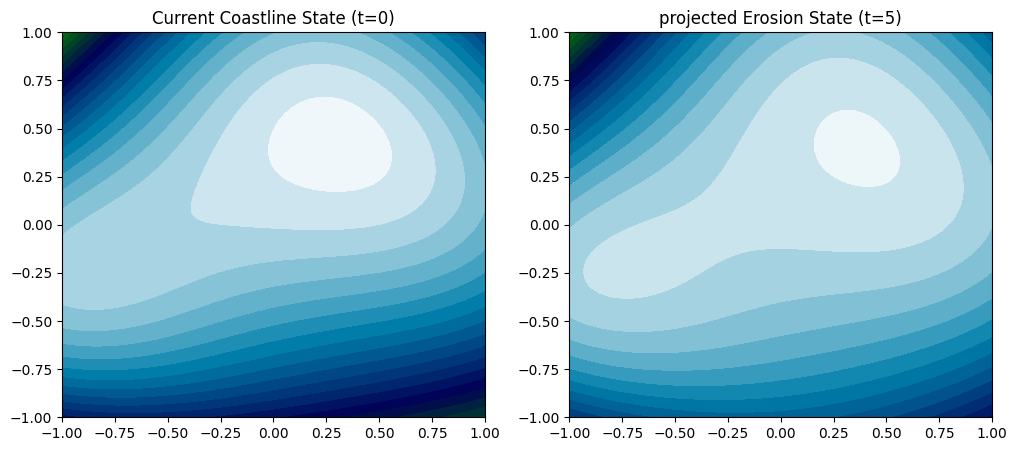

In [12]:
import ee
import geemap
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
try:
    # Attempt to initialize with specific project context
    ee.Initialize(project='extreme-lodge-471117-j8')
except Exception:
    ee.Authenticate()
    ee.Initialize(project='extreme-lodge-471117-j8')

# Coordinates for Lagos Coastline (Victoria Island / Eko Atlantic)
ROI = ee.Geometry.Rectangle([3.39, 6.40, 3.45, 6.45])

# --- DATA PIPELINE ---
def get_sentinel_data(roi):
    """
    Fetches Sentinel-2 satellite data and extracts coastline coordinates.
    Returns normalized training data for the neural network.
    """
    # Fetch satellite image
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(roi)
                  .filterDate('2025-01-01', '2026-01-30')
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                  .sort('system:time_start', False))

    image = collection.first()

    # Calculate NDWI and extract coastline vectors
    ndwi = image.normalizedDifference(['B3', 'B8'])
    canny = ee.Algorithms.CannyEdgeDetector(ndwi, threshold=0.5)

    # Convert edge detection to geometry vectors
    vectors = canny.toInt().reduceToVectors(
        geometry=roi, scale=30, geometryType='polygon',
        eightConnected=False, maxPixels=1e9
    )

    coords = vectors.geometry().coordinates().getInfo()

    # Flatten coordinates into a numpy array
    flat_coords = []
    for feature in coords:
        for line in feature:
            if isinstance(line[0], list):
                for point in line:
                    flat_coords.append(point)
            else:
                flat_coords.append(line)

    return np.array(flat_coords)

# --- PINN ARCHITECTURE ---
class ErosionPINN(nn.Module):
    def __init__(self):
        super(ErosionPINN, self).__init__()
        # Deep Neural Network (3 inputs -> 1 output)
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

def physics_loss(model, x, y, t):
    """
    Calculates the residual of the diffusion equation.
    Governing Equation: u_t = D * (u_xx + u_yy)
    """
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True

    u = model(torch.stack([x, y, t], dim=1))

    # Compute gradients
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Diffusion coefficient (D) estimated for coastal erosion
    D = 0.01
    residual = u_t - D * (u_xx + u_yy)
    return torch.mean(residual ** 2)

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Load Data
    raw_coords = get_sentinel_data(ROI)

    # Normalize data for training stability
    x_min, x_max = raw_coords[:, 0].min(), raw_coords[:, 0].max()
    y_min, y_max = raw_coords[:, 1].min(), raw_coords[:, 1].max()

    X_train = 2 * (raw_coords[:, 0] - x_min) / (x_max - x_min) - 1
    Y_train = 2 * (raw_coords[:, 1] - y_min) / (y_max - y_min) - 1

    # Prepare tensors
    x_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(Y_train, dtype=torch.float32)
    t_tensor = torch.zeros_like(x_tensor) # t=0 (Initial condition)

    input_data = torch.stack([x_tensor, y_tensor, t_tensor], dim=1)
    target = torch.ones_like(t_tensor).unsqueeze(1)

    # 2. Train Model
    model = ErosionPINN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 2000
    print(f"Starting training for {epochs} epochs...")

    for i in range(epochs):
        optimizer.zero_grad()

        # Compute losses
        prediction = model(input_data)
        loss_data = torch.mean((prediction - target) ** 2)
        loss_pde = physics_loss(model, x_tensor, y_tensor, t_tensor)

        total_loss = loss_data + loss_pde
        total_loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f"Epoch {i}: Loss {total_loss.item():.5f}")

    # 3. Visualization
    print("Generating projection maps...")
    grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    grid_tensor = torch.tensor(np.stack([grid_x.flatten(), grid_y.flatten()], axis=1), dtype=torch.float32)

    # Predict Year 0 vs Year 5
    t_0 = torch.zeros((len(grid_tensor), 1))
    t_5 = torch.ones((len(grid_tensor), 1)) * 0.5

    pred_0 = model(torch.cat([grid_tensor, t_0], dim=1)).detach().numpy().reshape(100, 100)
    pred_5 = model(torch.cat([grid_tensor, t_5], dim=1)).detach().numpy().reshape(100, 100)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Current Coastline State (t=0)")
    plt.contourf(grid_x, grid_y, pred_0, levels=20, cmap='ocean')

    plt.subplot(1, 2, 2)
    plt.title("projected Erosion State (t=5)")
    plt.contourf(grid_x, grid_y, pred_5, levels=20, cmap='ocean')
    plt.show()